# ComSeg tutorial

ComSeg is an algorithm to perform cell segmentation from RNA point clouds (single cell spatial RNA profiling) from FISH based spatial transcriptomic data. It takes as input a folder of CSV file containing the spots coordiantes of each images and a folder of nucleus segmentation masks for each image. If nucleus segmentation is not available, cell centroids are enough to apply ComSeg. 

This tutorial is organized as follow:  

1) Dataset initialization  
2) Create a graph of RNA molecule nodes and apply graph patitioning  
3) In situ clustering  
4) final RNA-nuclei association  


In [2]:
#### HYPERPARAMETER ####
MEAN_CELL_DIAMETER = 15  # in micrometer
MAX_CELL_RADIUS = 50  # in micrometer
#########################

## 1)  dataset initialization

The first step is to create a comseg-dataset. This object will preprocess the spot coordinates of each images from csv file, add optional prior knowledge and compute the co-expression correlation at the dataset scale.


You need a folder with your spots coordiantes **in pixel** csv files, with the naming convention {image_name}.csv 
 
You need a folder with you prior segmentation files, with the naming convention {image_name}.tiff

Download the test data for this tutorail at https://cloud.minesparis.psl.eu/index.php/s/HtYucchv9OGg6JN


In [3]:
import pandas as pd
import matplotlib
import comseg
import numpy as np
import random
import tifffile
import importlib
from comseg import dataset as ds
import scanpy
%matplotlib inline
import importlib
#importlib.reload(ds)

/home/tom/.local/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.3-CAPI-1.17.3) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [4]:

your_path_to_test_data = "/home/tom/Bureau/test_set_tutorial_comseg"


## path to you .csv spots coordinate folder
path_dataset_folder = your_path_to_test_data + "/small_df"


##path to your prior segmentation mask
path_to_mask_prior = your_path_to_test_data + "/mask"

## scale / pixel size in um 
dico_scale = {"x": 0.103, 'y': 0.103, "z": 0.3}


### create the dataset object 
dataset = ds.ComSegDataset(
            path_dataset_folder = path_dataset_folder,
            path_to_mask_prior =path_to_mask_prior,
            dict_scale={"x": 0.103, 'y': 0.103, "z": 0.3},
            mask_file_extension = ".tiff",
    mean_cell_diameter = MEAN_CELL_DIAMETER
)


### add prior knowledge, here using nucleus segmentation mask
dataset.add_prior_from_mask(prior_name = 'in_nucleus', 
                            overwrite = True,
                            compute_centroid = True # compute cell centroid 
                           )

add 07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_006
add 07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_004
add prior to 07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_006
prior added to 07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_006 and saved in csv file
dict_centroid added for 07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_006 
add prior to 07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_004
prior added to 07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_004 and saved in csv file
dict_centroid added for 07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_004 


The dataset class handles the spot coordinates, the position of cell centroid and the potential prior masks with the column `prior_keys_name = 'in_nucleus'`

In [5]:
dataset["07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_006"].head(5)

,x,y,z,gene,cell,cell_type,in_nucleus
0,945,436,13,C1qa,8,T_cells,0
1,1187,354,50,C1qa,8,T_cells,0
2,1109,348,8,C1qa,8,T_cells,0
3,644,528,18,C1qa,107,Club,0
4,668,659,45,C1qa,107,Club,0


In the fonction ``dataset.add_prior_from_mask()``, the centroid of each nucleus was also comuted and can be access as follow:

In [6]:
centroid = dataset.dict_centroid["07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_006"]
pd.DataFrame({"cell":  list(centroid.keys()),
              'centroid':  list(np.array(list(centroid.values())).round(2))}).head(5)

,cell,centroid
0,1,"[18.67, 14.87, 991.41]"
1,2,"[2.73, 26.92, 910.4]"
2,7,"[2.72, 318.71, 119.28]"
3,8,"[8.62, 385.52, 1082.46]"
4,9,"[15.13, 427.78, 255.53]"


#### Computation of the co-expression correlation at the dataset scale
In case of large dataset, the computation of the  co-expression correlation matrix can be speed up by reducing the 
``sampling_size`` parameter. ``sampling_size`` corresponds to the number of RNAs used to compute the co-expression matrix

In [7]:
### compute the co-expression correlation at the dataset scale
dico_proba_edge, count_matrix = dataset.compute_edge_weight(  # in micrometer
        images_subset = None,
        n_neighbors=40,
        sampling=True,
        sampling_size=10000
        )

  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                             | 0/2 [00:00<?, ?it/s]

image name :  07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_006


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 1/2 [00:04<00:04,  4.55s/it]

image name :  07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_004


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 161.57it/s]


#### The estimated co-expression correlation matrix between genes can be vizualised as folow

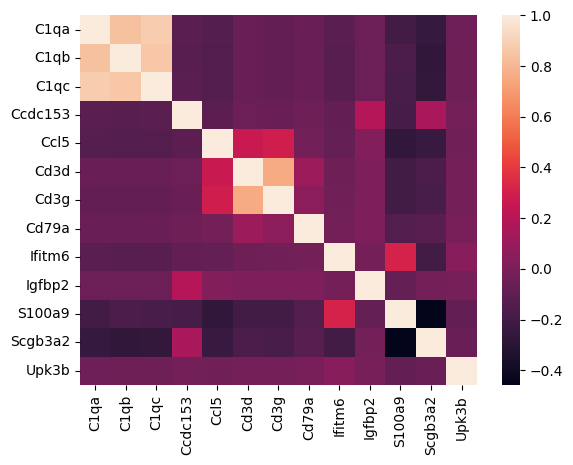

In [8]:
import seaborn as sns
from matplotlib import pyplot as plt
corr_matrix = []

for gene0 in  dataset.dict_co_expression:
    list_corr_gene0 = []
    for gene1 in dataset.dict_co_expression:
        list_corr_gene0.append(dataset.dict_co_expression[gene0][gene1])
    corr_matrix.append(list_corr_gene0)
list_gene = list(dataset.dict_co_expression.keys())
#plotting the heatmap for correlation
ax = sns.heatmap(corr_matrix, xticklabels = list_gene, yticklabels = list_gene,)
plt.show()

## 2) Create a graph of RNA molecule nodes and apply graph patitioning

 - we will use the previously computed co-expression matrix to weigth the KNN of graph of RNA
 - We will then partition this K-Nearest Neighbors (KNN) graph, into distinct communities of RNA molecules. These identified RNA communities are expected to group together neighboring RNA molecules that originate from co-expressed genes, and therefore, are likely to be from the same cell.

In [9]:
import comseg
from comseg import model
from comseg import dictionary

In [10]:
Comsegdict = dictionary.ComSegDict(
                 dataset=dataset,
                 mean_cell_diameter= MEAN_CELL_DIAMETER,
                 community_detection="with_prior",
)


Comsegdict.compute_community_vector()


  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                             | 0/2 [00:00<?, ?it/s]

improvement of modularity 0.5080609674415066
improvement of modularity 0.13043304254379018
improvement of modularity 0.028383279306623543
improvement of modularity 0.0016052913962985027


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 1/2 [00:05<00:05,  5.62s/it]

improvement of modularity 0.5102057959603735
improvement of modularity 0.1323224134371781
improvement of modularity 0.02923012975231931
improvement of modularity 0.0018413954689118217


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:13<00:00,  6.60s/it]


## 3) In situ clustering

In the previous step we create a graph of RNA nodes and spits this graph into community of RNA.  
In this step we will extract the RNA profil of all RNA communities and cluster the communities RNA profiles to estimate the different transciptomic profile present into the input tissue

In [11]:
Comsegdict.compute_insitu_clustering(
                                  size_commu_min=3,
                                  norm_vector=True,
                                  ### parameter clustering
                                  n_pcs=3,
                                  n_comps=3,
                                  clustering_method="leiden",
                                  n_neighbors=20,
                                  resolution=1,
                                  n_clusters_kmeans=4,
                                  palette=None,
                                  nb_min_cluster=0,
                                  min_merge_correlation=0.8,
                                  )

/home/tom/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Writing temporary files...
Running scTransform via Rscript...

Attaching package: arrow

The following objects are masked from package:feather:

    read_feather, write_feather

The following object is masked from package:utils:

    timestamp

Calculating cell attributes from input UMI matrix: log_umi
Variance stabilizing transformation of count matrix of size 13 by 486
Model formula is y ~ log_umi
Get Negative Binomial regression parameters per gene
Using 13 genes, 486 cells
  |======================================================================| 100%
Second step: Get residuals using fitted parameters for 13 genes
  |======================================================================| 100%
Calculating gene attributes
Wall clock passed: Time difference of 0.2802873 secs
Reading output files...
Clipping residuals...


2024-06-11 16:54:10.467164: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


number of cluster 7
number of cluster after merging 8


AnnData object with n_obs × n_vars = 639 × 13
    obs: 'list_coord', 'node_index', 'prior', 'index_commu', 'nb_rna', 'img_name', 'leiden', 'leiden_merged'

### PLOT IN SITU CLUSTERING
Next, we will create a UMAP visualization of the RNA profiles within each community. Specifically, each RNA community is linked to an expression vector. We then cluster these community expression vectors in a similar manner to how we would cluster single-cell RNA sequencing (scRNAseq) data. In the following UMAP, each dot corresponds to one RNA community.

/home/tom/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


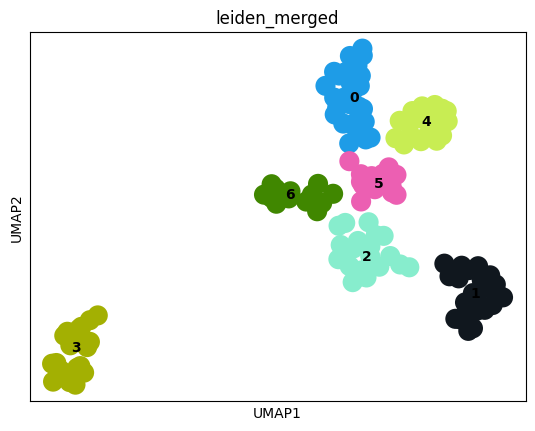

In [12]:
import scanpy as sc
import random
palette = {}
for i in range(-1, 500):
    palette[str(i)] = "#" + "%06x" % random.randint(0, 0xFFFFFF)
adata = Comsegdict.in_situ_clustering.anndata_cluster
adata.obs["leiden_merged"] = adata.obs["leiden_merged"].astype(str)
sc.tl.umap(adata)
fig_ledien = sc.pl.umap(adata, color=["leiden_merged"], palette=palette, legend_loc='on data',
                )

###  Transcriptomic domain map 
After this step, each node in the graph is labeled by its identified transcriptomic profile $L_i$ using the previous UMAP.  
Hence it is possible to plot a transcriptomic domain map showing the transcriptomic heterogenity at the tissue level using the $L_i$  profiles of the RNA communities.

In [13]:
Comsegdict.add_cluster_id_to_graph(clustering_method = "leiden_merged")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11410/11410 [00:00<00:00, 595466.02it/s]


"ComSegDict {'07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_006': <comseg.model.ComSegGraph object at 0x7f23f4567a90>, '07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_004': <comseg.model.ComSegGraph object at 0x7f23e467f040>}"

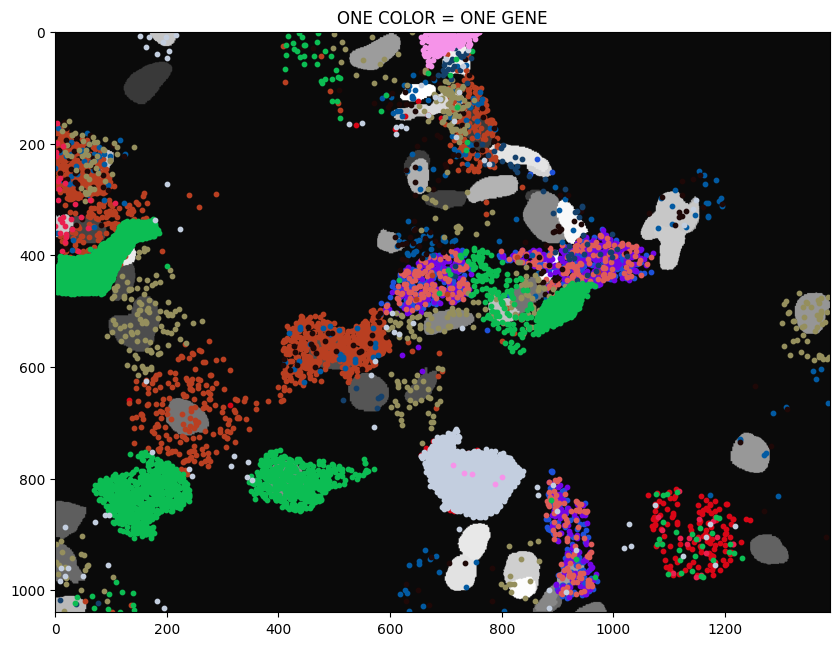

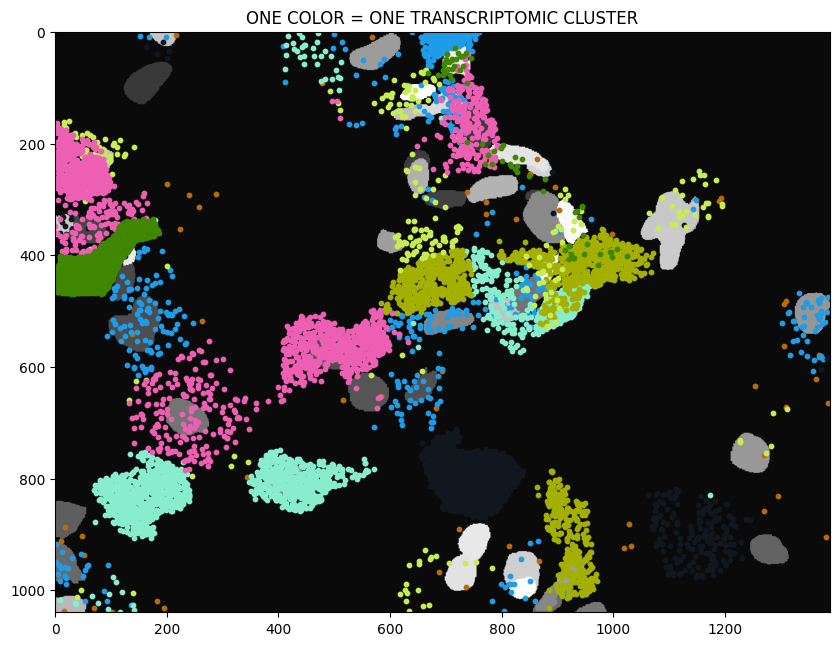

In [14]:
from comseg.utils import plot
importlib.reload(plot)
img_name = list(Comsegdict.keys())[1]
G = Comsegdict[img_name].G
nuclei = tifffile.imread(
    your_path_to_test_data + f'/mask/{img_name}.tiff')


fig, ax = plot.plot_result(G=G,
            nuclei = nuclei,
               key_node = 'gene',
                dico_cell_color = None,
                figsize=(10, 10),
                spots_size = 10,
                title  = "ONE COLOR = ONE GENE")

fig, ax = plot.plot_result(G=G,
            nuclei = nuclei,
               key_node = 'leiden_merged',
                dico_cell_color = palette,
                figsize=(10, 10),
                spots_size = 10,
                title  = "ONE COLOR = ONE TRANSCRIPTOMIC CLUSTER")

## 4) final RNA-nuclei association

### Classify nuclei centroid

We will now categorize each nucleus based on the domain map that was computed earlier. The centroid of each nucleus is labeled by the transcriptomic profile that is most prevalent in its surrounding area.  
Of note cell centroid can also be loaded from an external folder with one dataframe or dictionnary per images containing  the centroid coodinate



In [15]:
Comsegdict.classify_centroid(
          n_neighbors=15,
          dict_in_pixel=True,
          max_dist_centroid=None,
          key_pred="leiden_merged",
          distance="ngb_distance_weights",
                        )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.53it/s]


### todo add a vizualization of the classify nuclei

### Apply dikstra

We now utilize the Dijkstra's algorithm to link each nucleus centroid to the closest RNAs that are labeled with the same transcriptomic cluster.

In [16]:
Comsegdict.associate_rna2landmark(
                         key_pred = "leiden_merged",
                         distance='distance',
                         max_cell_radius=MAX_CELL_RADIUS)

  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                             | 0/2 [00:00<?, ?it/s]

07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_006


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 1/2 [00:02<00:02,  2.65s/it]

07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.51s/it]


### Plot of final RNA-NUCLEUS assignement

(<Figure size 1500x1500 with 1 Axes>,
 <Axes: title={'center': 'cell_index_pred'}>)

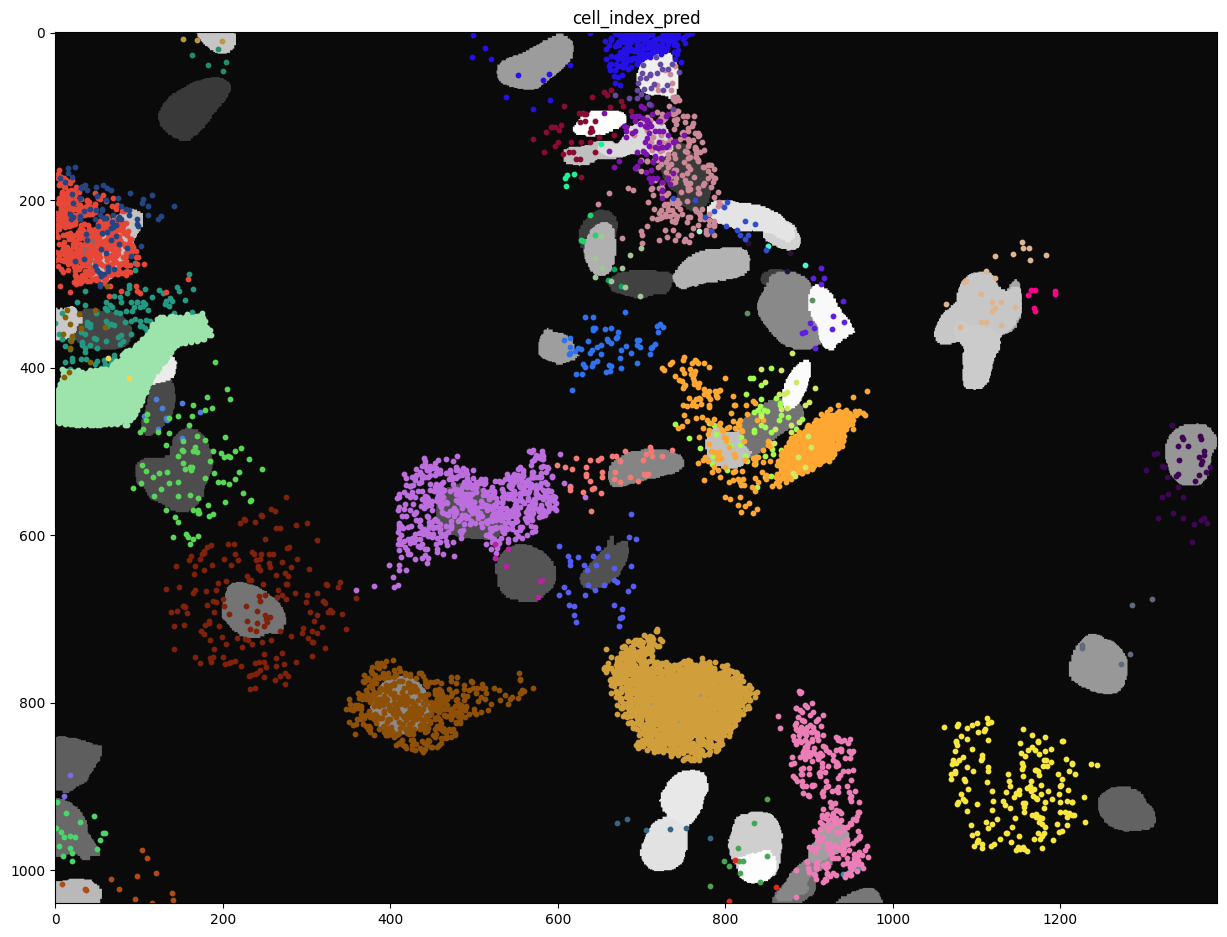

In [17]:
importlib.reload(comseg)
from comseg.utils import plot 
importlib.reload(plot)

G = Comsegdict[img_name].G
nuclei = tifffile.imread(
    your_path_to_test_data + f'/mask/{img_name}.tiff')

plot.plot_result(G=G,
            nuclei = nuclei,
               key_node = 'cell_index_pred',
                title = None,
                dico_cell_color = None,
                figsize=(15, 15),
                spots_size = 10,
                plot_outlier = False)

### OUTPUT ANNDATA

the final output of this pipeline is an AnnData object so our model can be integrated into Scanpy/Scverse single cell workflow analysis. 
It contains for each cell an exppression vector, the cell centroid coordinates and the molecule coordinates associated to this cell.

In [18]:
anndata ,jsons = Comsegdict.anndata_from_comseg_result(                
                        return_polygon = False,
                        alpha = 0.6,
                        min_rna_per_cell = 5)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 19.18it/s]


In [19]:
Comsegdict.final_anndata.uns['df_spots']['07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_006'].head(5)

,node_index,x,y,z,gene,cell,cell_type,in_nucleus,nb_mol,index_commu,leiden_merged,cell_index_pred,distance2centroid
0,0,945,436,13,C1qa,8,T_cells,0,1,0,4,0,inf
1,1,1187,354,50,C1qa,8,T_cells,0,1,1,-1,0,inf
2,2,1109,348,8,C1qa,8,T_cells,0,1,2,4,0,inf
3,3,644,528,18,C1qa,107,Club,0,1,3,1,107,8.438355
4,4,668,659,45,C1qa,107,Club,0,1,4,1,107,15.896867


### Final single cell clustering from the anndata

/home/tom/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


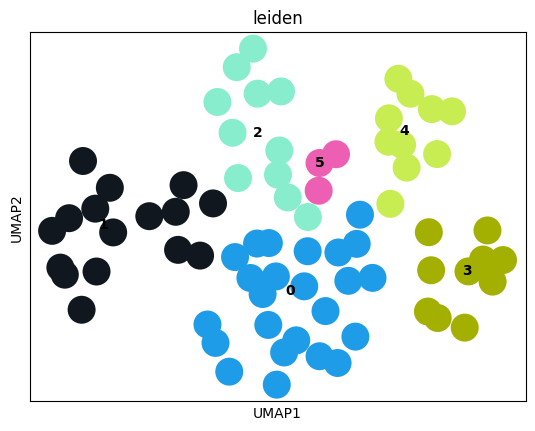

In [20]:

adata = Comsegdict.final_anndata
#sc.tl.pca(adata, svd_solver='arpack', n_comps = 0)
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=0)
sc.tl.leiden(adata,  resolution=1)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["leiden"], palette=palette, legend_loc='on data')


### Save annData

In [21]:
from pathlib import Path
anndata.write_h5ad( Path(your_path_to_test_data) / "result.h5ad")

### relaod it 

In [22]:
sc.read_h5ad(Path(your_path_to_test_data) / "result.h5ad")

AnnData object with n_obs × n_vars = 74 × 13
    obs: 'CellID', 'Name', 'centroid_z', 'centroid_y', 'centroid_x', 'image_name', 'leiden'
    var: 'features'
    uns: 'df_spots', 'leiden', 'leiden_colors', 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'connectivities', 'distances'